In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark", 
              palette="pastel")
sns.set(rc={"figure.dpi":300, 
            'savefig.dpi':300})
from utils.plot import draw_graph

from data.dataset import PolygonDataset
from train.trainer import Trainer

from model.nn import build_model
from torchinfo import summary

with open('cfg/gae.yaml', 'r') as f:
    cfg = yaml.safe_load(f)  

import pandas as pd
glyph_df = pd.read_pickle(cfg['test'])
osm_df = pd.read_pickle(cfg['osm'])
melb_df = pd.read_pickle(cfg['melb'])

glyh_df_o = glyph_df[glyph_df.trans == 'o'].reset_index(drop=True).sort_values('name')
osm_df_r = osm_df[osm_df.trans == 'r'].reset_index(drop=True)   
osm_df_o = osm_df[osm_df.trans == 'o'].reset_index(drop=True)  

glyph_set = PolygonDataset(glyh_df_o)
osm_set_r = PolygonDataset(osm_df_r)
osm_set_o = PolygonDataset(osm_df_o)
melb_set = PolygonDataset(melb_df)

In [2]:
cfg['nn'] = 'gcn'
cfg['path'] = f'save/baseline/{cfg["nn"]}'

model = build_model(cfg=cfg)
print(summary(model))

trainer = Trainer(cfg=cfg) 
model = trainer.load_ckpt(model, ckpt='epoch100')

Layer (type:depth-idx)                   Param #
GAE                                      --
├─GCNBlock: 1-1                          --
│    └─GCNConv: 2-1                      64
│    │    └─SumAggregation: 3-1          --
│    │    └─Linear: 3-2                  128
│    └─GCNConv: 2-2                      64
│    │    └─SumAggregation: 3-3          --
│    │    └─Linear: 3-4                  4,096
│    └─LayerNorm: 2-3                    128
│    └─PReLU: 2-4                        1
├─GCNBlock: 1-2                          --
│    └─GCNConv: 2-5                      64
│    │    └─SumAggregation: 3-5          --
│    │    └─Linear: 3-6                  4,096
│    └─GCNConv: 2-6                      2
│    │    └─SumAggregation: 3-7          --
│    │    └─Linear: 3-8                  128
│    └─LayerNorm: 2-7                    128
│    └─PReLU: 2-8                        1
Total params: 8,900
Trainable params: 8,900
Non-trainable params: 0


### Feature Reduction -- Glyphs

In [3]:
zs, ns = [], []
for data in glyph_set:
    data.to('cuda')
    adj, z = model.decode(data.pos, data.edge_index)

    zs.append(z.mean(0).detach().cpu().numpy())
    ns.append(z.sum(-1).sigmoid().detach().cpu().numpy())
    
zs = np.asarray(zs)

In [4]:
from sklearn.manifold import TSNE
zs_low = TSNE(n_components=2, 
              learning_rate='auto', 
              init='pca', 
              perplexity=50,
              n_jobs=-1).fit_transform(zs)

/home/ubuntu/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


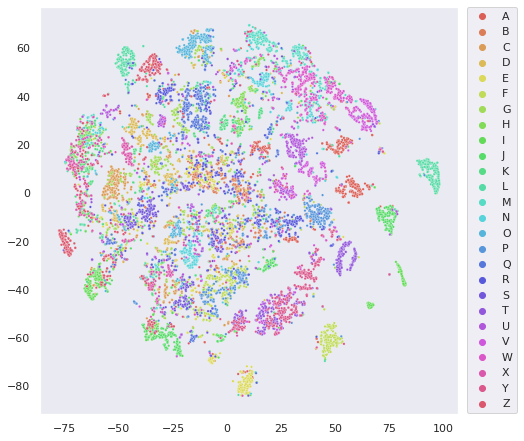

In [5]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
y = np.asarray(glyh_df_o['name'].tolist())

sns.scatterplot(x=zs_low[:,0], 
                y=zs_low[:,1], 
                hue=y,
                palette=sns.hls_palette(26), 
                legend=True, 
                s=6, 
                ax=ax)

ax.legend(bbox_to_anchor=(1.02, 1.0), 
          ncol=1,
          loc='upper left', 
          borderaxespad=0)

### Shape Retrival -- OSM 

In [6]:
zs_r, ns_r = [], []
for data in osm_set_r:
    data.to('cuda')
    adj, z = model.decode(data.pos, data.edge_index)

    zs_r.append(z.mean(0).detach().cpu().numpy())
    ns_r.append(z.sum(-1).sigmoid().detach().cpu().numpy())
    
zs_r = np.asarray(zs_r)

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=7, algorithm='auto').fit(zs_r)
dist, idx = nbrs.kneighbors(zs_r)

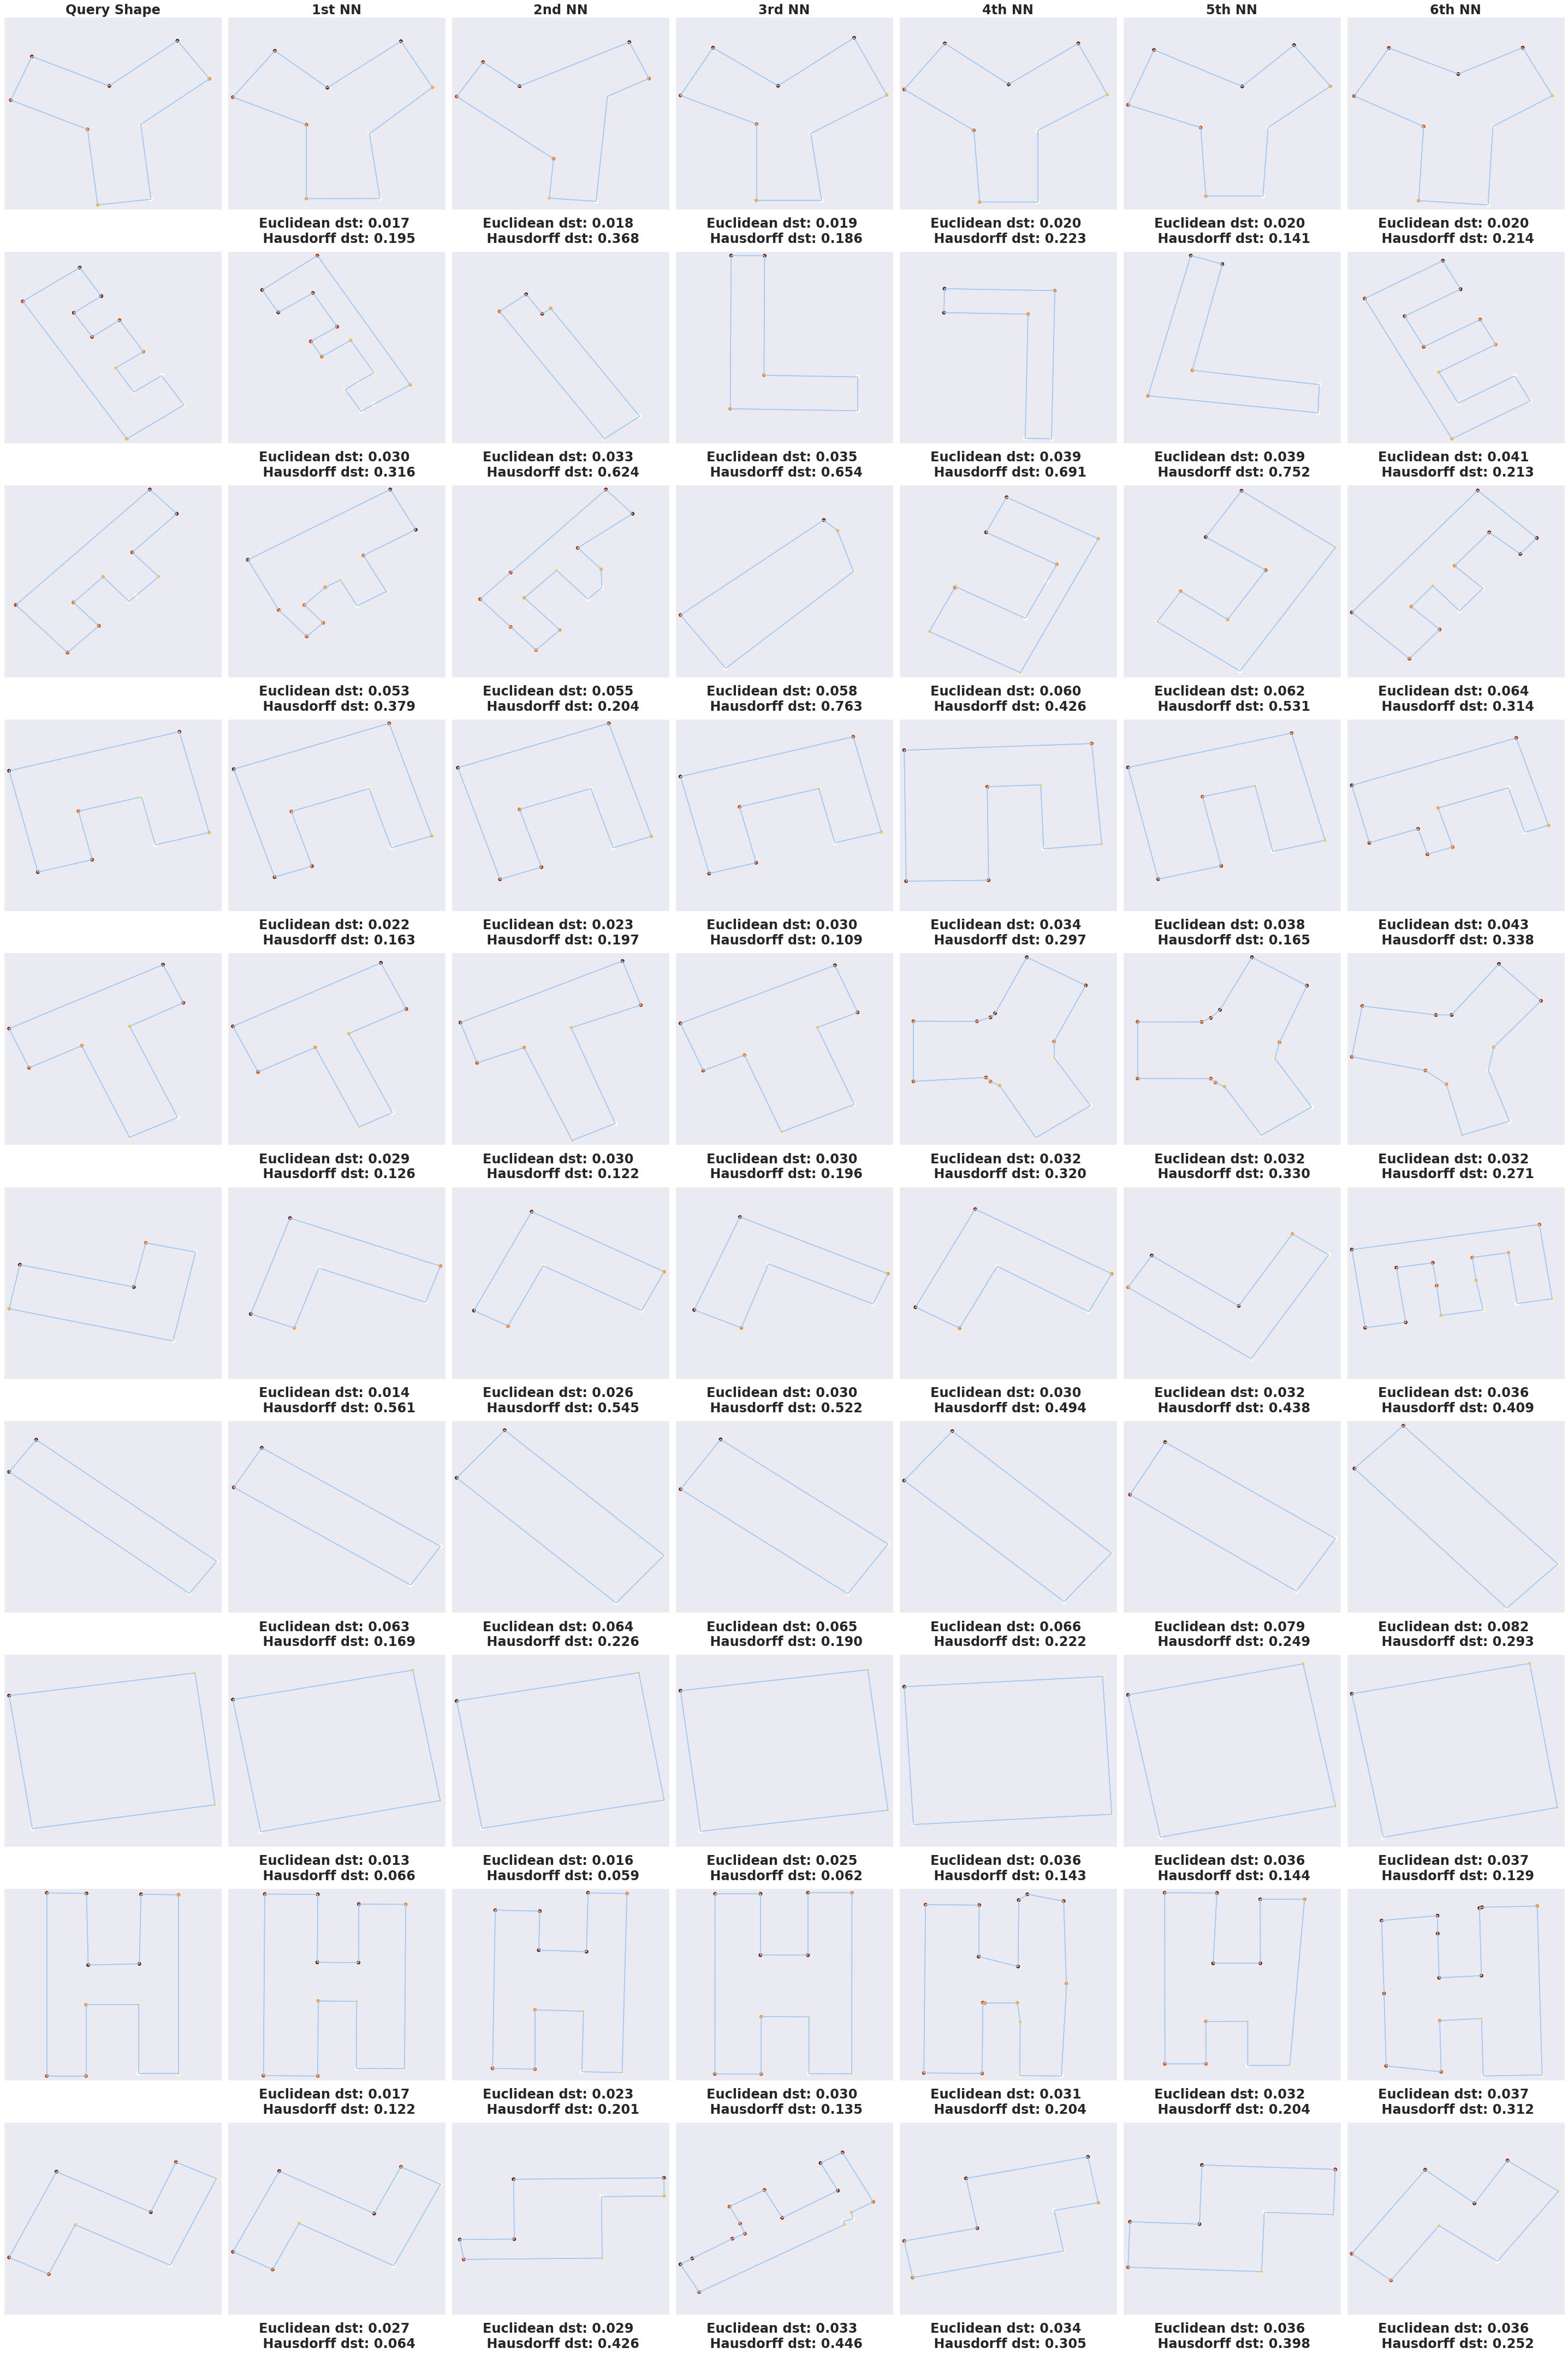

In [7]:
query_id = osm_df_r.index.tolist()[-10:]  # standard shapes 
figs, axs = plt.subplots(len(query_id), 7, 
                         figsize=(40, len(query_id) * 6))

for row, qid in zip(axs, query_id):
    ids = idx[qid]
    dst = dist[qid]
    for id, col in enumerate(row):
        query = osm_set_r[ids[0]]
        data = osm_set_r[ids[id]]
        node = ns_r[ids[id]]
        draw_graph(data.pos.cpu().numpy(), 
                   data.edge_index.t().cpu().numpy(), 
                   node,
                   ax=col)
        col.set(xticklabels=[])
        col.set(yticklabels=[])
        col.axis(ymin=-1.05, ymax=1.05)
        col.axis(xmin=-1.05, xmax=1.05)
        if id != 0: 
            from scipy.spatial.distance import directed_hausdorff
            hau_dist = directed_hausdorff(query.pos.cpu().numpy(), data.pos.cpu().numpy())[0]
            col.set_xlabel(f'Euclidean dst: {dst[id]:.3f} \n Hausdorff dst: {hau_dist:.3f}', 
                           fontweight='bold', fontsize=24)
   
axs[0,0].set_title('Query Shape', fontweight='bold', fontsize=24)
axs[0,1].set_title('1st NN', fontweight='bold', fontsize=24)
axs[0,2].set_title('2nd NN', fontweight='bold', fontsize=24)
axs[0,3].set_title('3rd NN', fontweight='bold', fontsize=24)
axs[0,4].set_title('4th NN', fontweight='bold', fontsize=24)
axs[0,5].set_title('5th NN', fontweight='bold', fontsize=24)
axs[0,6].set_title('6th NN', fontweight='bold', fontsize=24)
plt.tight_layout()

In [8]:
zs_o, ns_o = [], []
for data in osm_set_o:
    data.to('cuda')
    adj, z = model.decode(data.pos, data.edge_index)

    zs_o.append(z.mean(0).detach().cpu().numpy())
    ns_o.append(z.sum(-1).sigmoid().detach().cpu().numpy())
    
zs_o = np.asarray(zs_o)

nbrs = NearestNeighbors(n_neighbors=7, algorithm='auto').fit(zs_o)
dist, idx = nbrs.kneighbors(zs_o)

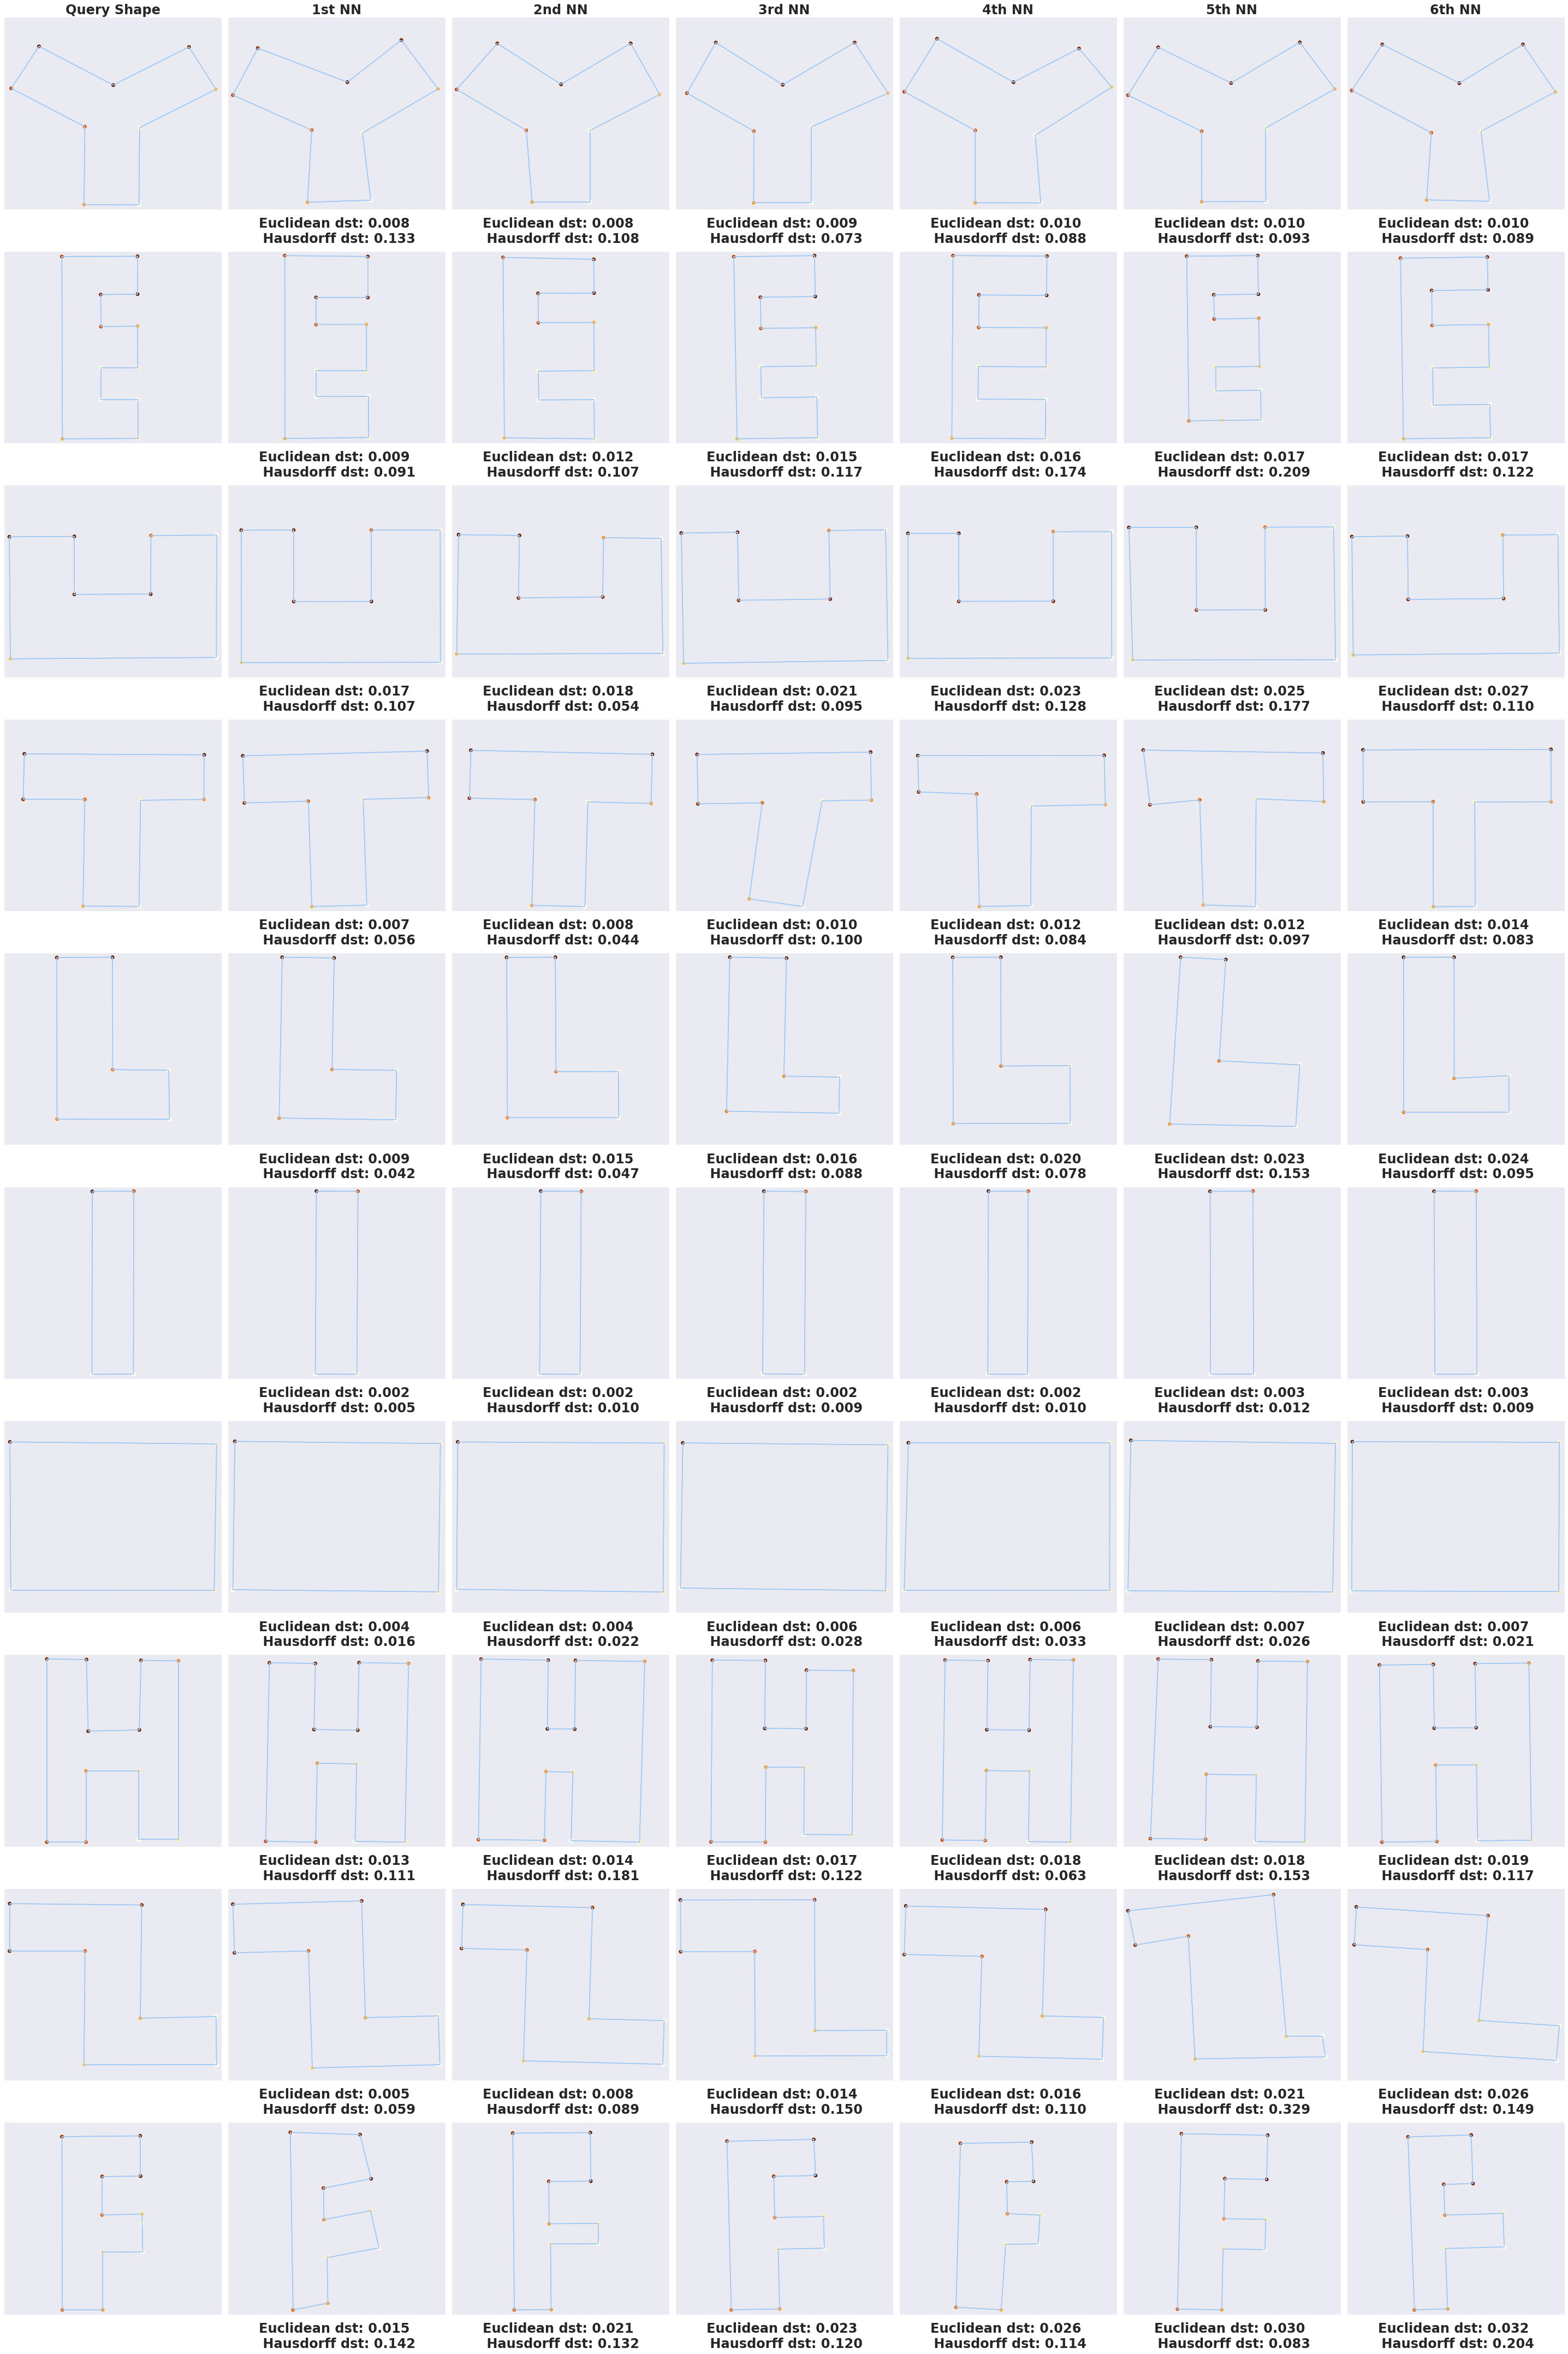

In [9]:
query_id = osm_df_o.index.tolist()[-10:]  # standard shapes 
figs, axs = plt.subplots(len(query_id), 7, 
                         figsize=(40, len(query_id) * 6))

for row, qid in zip(axs, query_id):
    ids = idx[qid]
    dst = dist[qid]
    for id, col in enumerate(row):
        query = osm_set_o[ids[0]]
        data = osm_set_o[ids[id]]
        node = ns_o[ids[id]]
        draw_graph(data.pos.cpu().numpy(), 
                   data.edge_index.t().cpu().numpy(), 
                   node,
                   ax=col)
        col.set(xticklabels=[])
        col.set(yticklabels=[])
        col.axis(ymin=-1.05, ymax=1.05)
        col.axis(xmin=-1.05, xmax=1.05)
        if id != 0: 
            hau_dist = directed_hausdorff(query.pos.cpu().numpy(), data.pos.cpu().numpy())[0]
            col.set_xlabel(f'Euclidean dst: {dst[id]:.3f} \n Hausdorff dst: {hau_dist:.3f}', 
                           fontweight='bold', fontsize=24)
   
axs[0,0].set_title('Query Shape', fontweight='bold', fontsize=24)
axs[0,1].set_title('1st NN', fontweight='bold', fontsize=24)
axs[0,2].set_title('2nd NN', fontweight='bold', fontsize=24)
axs[0,3].set_title('3rd NN', fontweight='bold', fontsize=24)
axs[0,4].set_title('4th NN', fontweight='bold', fontsize=24)
axs[0,5].set_title('5th NN', fontweight='bold', fontsize=24)
axs[0,6].set_title('6th NN', fontweight='bold', fontsize=24)
plt.tight_layout()

### Shape Retrival -- Melbourne

In [10]:
zs_mb, ns_mb = [], []
for data in melb_set:
    data.to('cuda')
    adj, z = model.decode(data.pos, data.edge_index)
    
    zs_mb.append(z.mean(0).detach().cpu().numpy())
    ns_mb.append(z.sum(-1).sigmoid().detach().cpu().numpy())
    
zs_mb = np.asarray(zs_mb)
# remove nan
zs_mb = zs_mb[~np.isnan(zs_mb).any(axis=1)]

nbrs = NearestNeighbors(n_neighbors=7, algorithm='auto').fit(zs_mb)
dist, idx = nbrs.kneighbors(zs_mb)

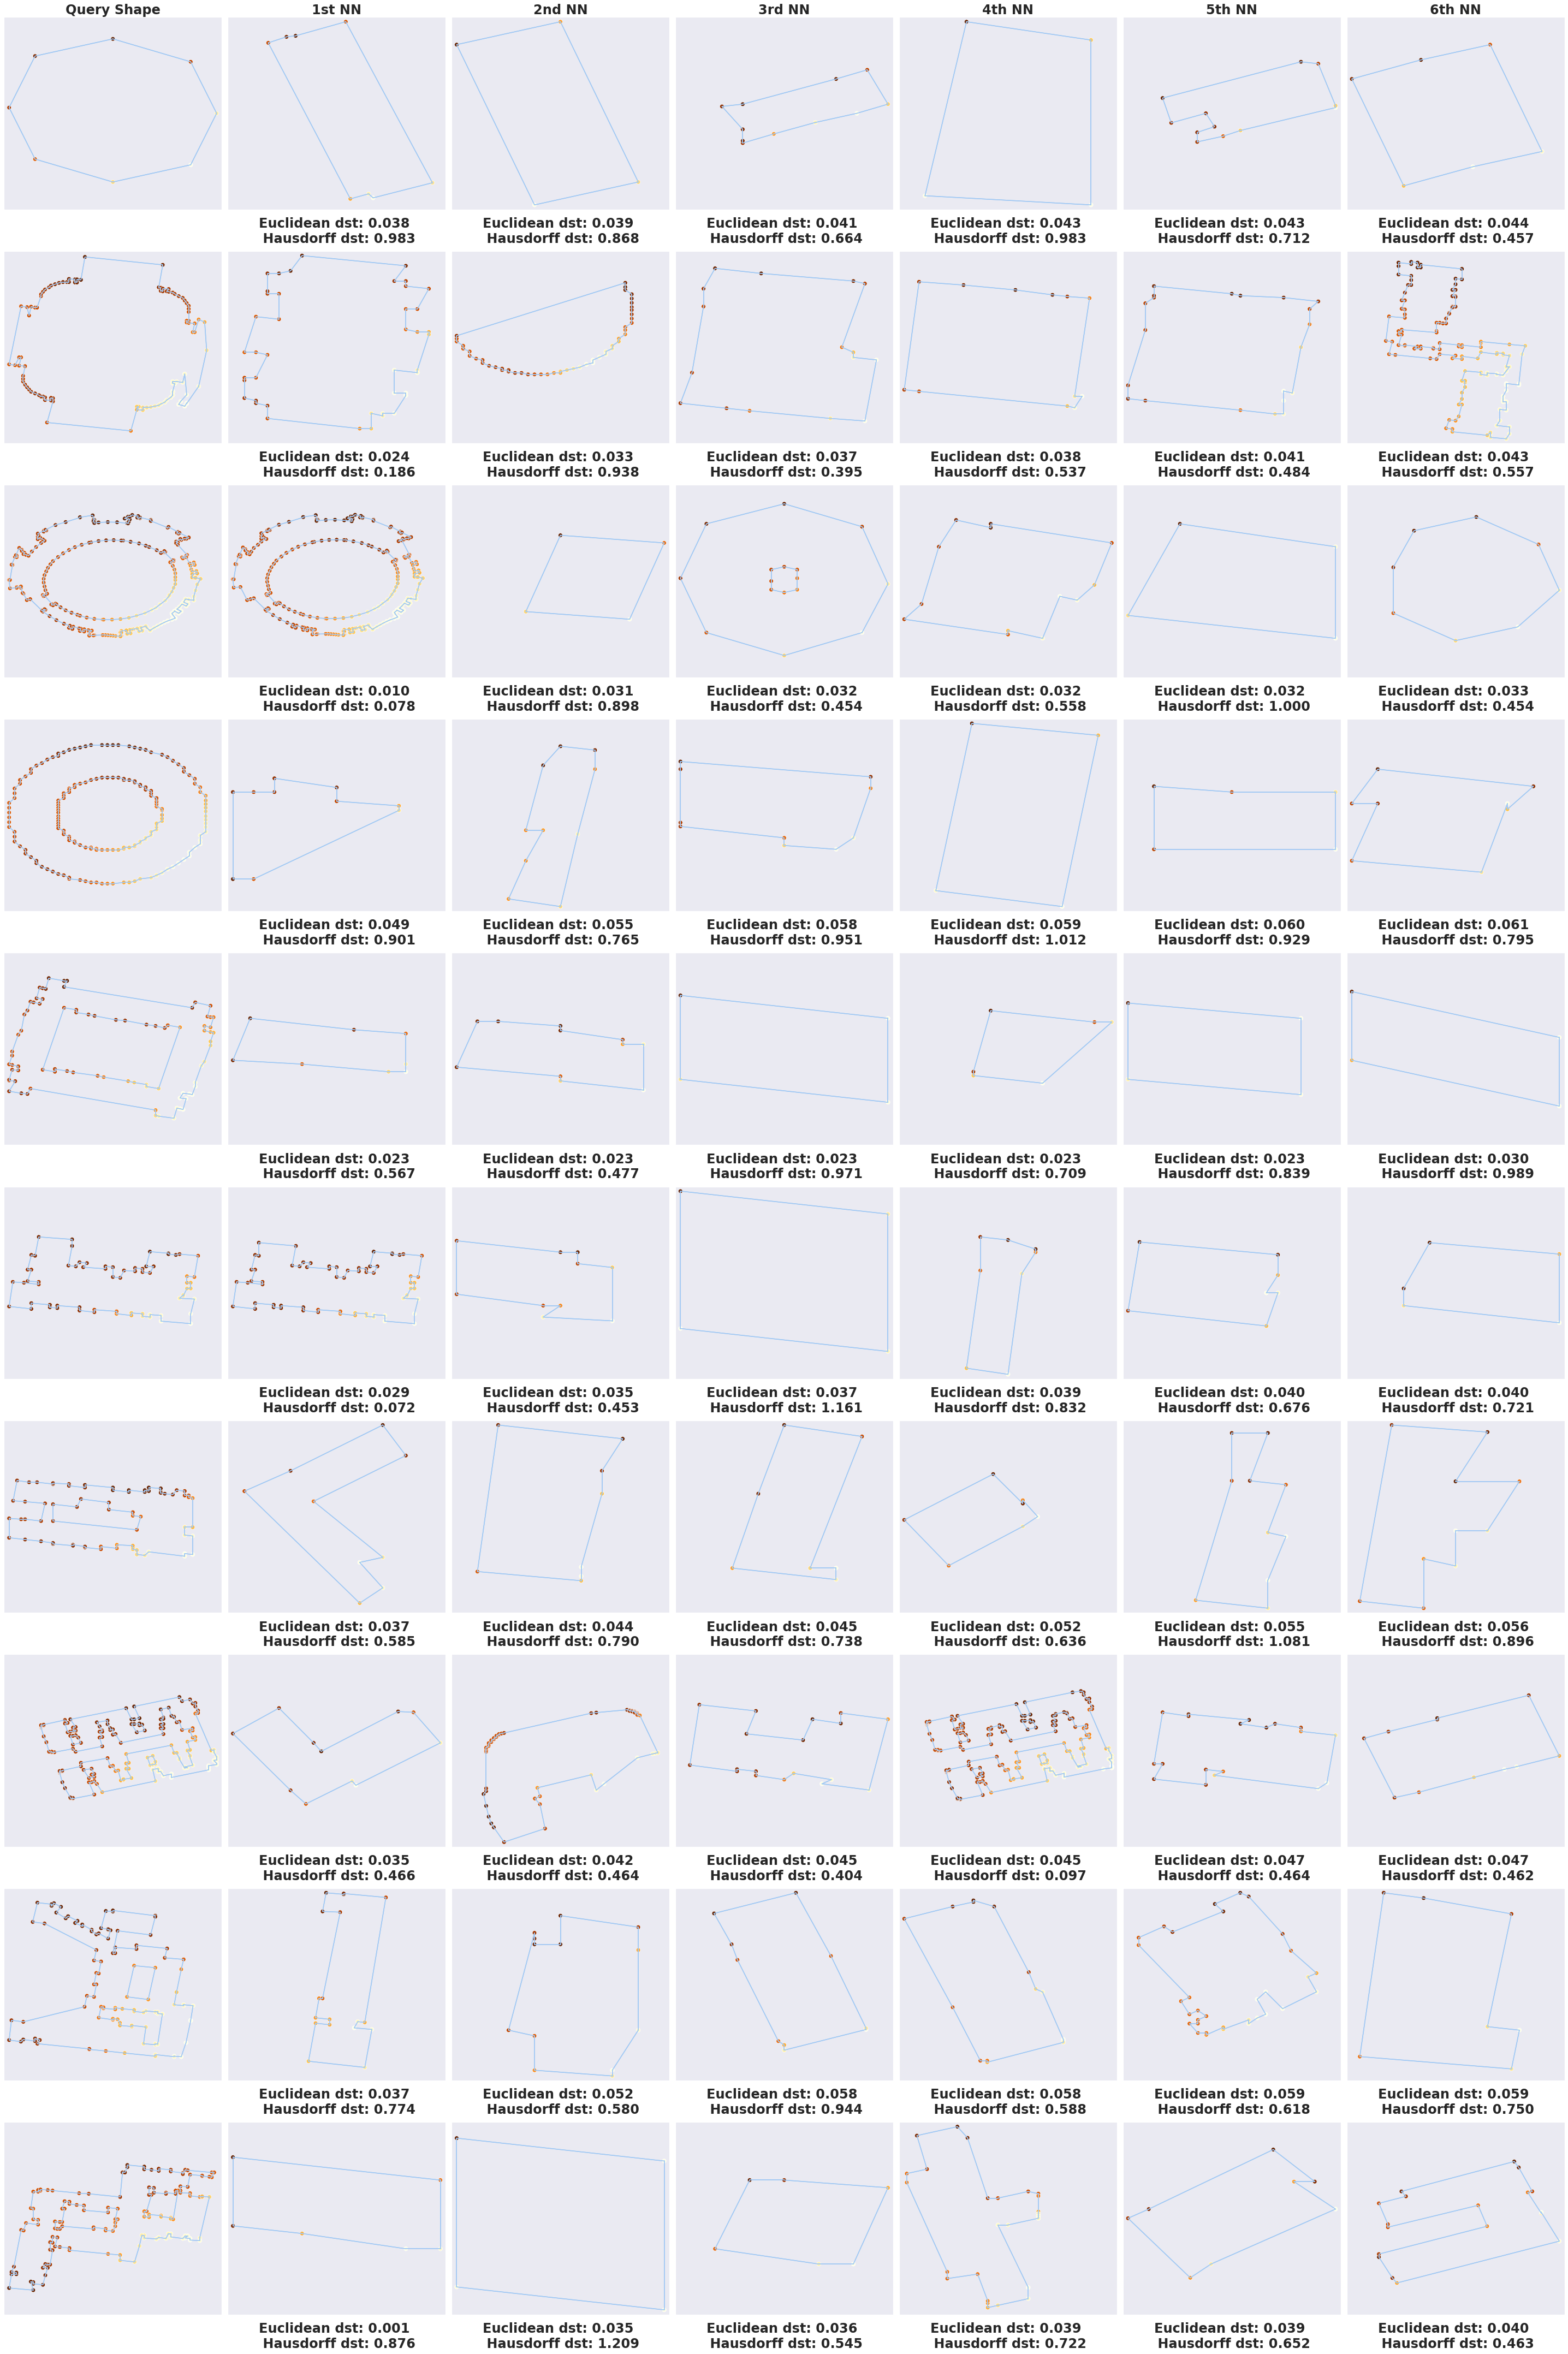

In [11]:
query_id = [26258, 9012, 5811, 28789, 30772,
            32358, 18329, 9968, 9787, 11576] # query shapes 

figs, axs = plt.subplots(len(query_id), 7, 
                         figsize=(40, len(query_id) * 6))

for row, qid in zip(axs, query_id):
    ids = idx[qid]
    dst = dist[qid]
    for id, col in enumerate(row):
        query = melb_set[ids[0]]
        data = melb_set[ids[id]]
        node = ns_mb[ids[id]]
        draw_graph(data.pos.cpu().numpy(), 
                   data.edge_index.t().cpu().numpy(), 
                   node,
                   ax=col)
        col.set(xticklabels=[])
        col.set(yticklabels=[])
        col.axis(ymin=-1.05, ymax=1.05)
        col.axis(xmin=-1.05, xmax=1.05)
        if id != 0: 
            hau_dist = directed_hausdorff(query.pos.cpu().numpy(), data.pos.cpu().numpy())[0]
            col.set_xlabel(f'Euclidean dst: {dst[id]:.3f} \n Hausdorff dst: {hau_dist:.3f}', 
                           fontweight='bold', fontsize=24)
   
axs[0,0].set_title('Query Shape', fontweight='bold', fontsize=24)
axs[0,1].set_title('1st NN', fontweight='bold', fontsize=24)
axs[0,2].set_title('2nd NN', fontweight='bold', fontsize=24)
axs[0,3].set_title('3rd NN', fontweight='bold', fontsize=24)
axs[0,4].set_title('4th NN', fontweight='bold', fontsize=24)
axs[0,5].set_title('5th NN', fontweight='bold', fontsize=24)
axs[0,6].set_title('6th NN', fontweight='bold', fontsize=24)
plt.tight_layout()